<a href="https://colab.research.google.com/github/anjaleeDS/Sandbox/blob/master/miniStock_analysisUsing_FBProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Personal tool for finding components from stocks



##Setup

*   Libs
*   Mount Drive for Data
*   Settings

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
import altair as alt
import datetime as dt
import numpy as np

#### get from gdrive
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
# %cd /gdrive/My\ Drive/
# %cd Colab\ Notebooks
# %cd Sandbox

#### get from gsheets
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

pd.set_option('max_rows', 100)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

plt.style.use('fivethirtyeight')

#viridis scheme

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


## Get data from gsheets



In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My\ Drive/
%cd Colab\ Notebooks
%cd Sandbox

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks
/gdrive/My Drive/Colab Notebooks/Sandbox


In [3]:
worksheet = gc.open('baba_stock').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame
stock_df = pd.DataFrame.from_records(rows)




## Fix / normalize data 

- fix the index using first line in gsheet as header
- take out erroneous non-chars from column name
- remove rows that were not daily reading of stock
- strip out commas in Volume column
- assign correct types to columns (datetime, float and ints)

In [4]:
# correct header and index
stock_df = stock_df.rename(columns=stock_df.iloc[0])
stock_df = stock_df.drop(stock_df.index[0])
stock_df = stock_df.reset_index(drop=True)
stock_df.columns = [c.replace(' ', '_') for c in stock_df.columns] # for the columns that are multiple words
stock_df.columns = [c.replace('*', '') for c in stock_df.columns] # take out the random non letters in the column name

stock_df.Volume = stock_df.Volume.replace(',','', regex=True)

stock_df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,"Jul 28, 2020",251.15,251.65,248.53,249.05,249.05,9869200
1,"Jul 27, 2020",247.11,252.87,245.81,250.86,250.86,18966900
2,"Jul 24, 2020",244.96,249.48,241.89,249,249,17221500
3,"Jul 23, 2020",252.1,257.66,248.69,251.88,251.88,25712000
4,"Jul 22, 2020",255.76,256.27,249.6,251.7,251.7,19682200


In [5]:

# Get rid of the broken rows
w_df = stock_df[stock_df.High!='']

# Make Date column a date type and others floats
w_df.Date = pd.to_datetime(w_df.Date, errors='coerce')
w_df.Adj_Close = pd.to_numeric(w_df.Adj_Close, errors='coerce')
w_df.Close= pd.to_numeric(w_df.Close, errors='coerce')
w_df.Low=pd.to_numeric(w_df.Low, errors='coerce')
w_df.High=pd.to_numeric(w_df.High, errors='coerce')
w_df.Open=pd.to_numeric(w_df.Open, errors='coerce')
w_df.Volume = w_df.Volume.astype('int64')

w_df.head()


,Date,Open,High,Low,Close,Adj_Close,Volume
0,2020-07-28,251.15,251.65,248.53,249.05,249.05,9869200
1,2020-07-27,247.11,252.87,245.81,250.86,250.86,18966900
2,2020-07-24,244.96,249.48,241.89,249.00,249.00,17221500
3,2020-07-23,252.10,257.66,248.69,251.88,251.88,25712000
4,2020-07-22,255.76,256.27,249.60,251.70,251.70,19682200


## Create/format dataframe that FBProphet can work with

In [6]:
# format into FBProphet inputs
pdf = w_df[['Date','Low']] 
pdf.rename(columns={'Date': 'ds', 'Low': 'y'},inplace=True)
# pdf

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Create model and period for prediction

In [7]:
my_model = Prophet(interval_width=0.95, yearly_seasonality=True, daily_seasonality=True) #system advises to put yearly and daily "*_seasonality=True"
my_model.fit(pdf)

# tell how long out you want to predict
future_dates =  my_model.make_future_dataframe(periods=9, freq='MS')

# add the future to your model
forecast =  my_model.predict(future_dates)
forecast.tail()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
257,2020-12-01,276.547881,261.296218,281.916684,276.453719,276.636267,-4.848029,-4.848029,-4.848029,-12.883902,-12.883902,-12.883902,-0.414110,-0.414110,-0.414110,8.449983,8.449983,8.449983,0.0,0.0,0.0,271.699853
258,2021-01-01,283.150458,284.613890,304.551363,283.021223,283.275094,11.660635,11.660635,11.660635,-12.883902,-12.883902,-12.883902,-0.719556,-0.719556,-0.719556,25.264093,25.264093,25.264093,0.0,0.0,0.0,294.811093
259,2021-02-01,289.753035,278.045820,299.068308,289.585832,289.917535,-1.152162,-1.152162,-1.152162,-12.883902,-12.883902,-12.883902,-1.644359,-1.644359,-1.644359,13.376099,13.376099,13.376099,0.0,0.0,0.0,288.600873
260,2021-03-01,295.716653,272.660291,292.072373,295.511726,295.916992,-12.949110,-12.949110,-12.949110,-12.883902,-12.883902,-12.883902,-1.644359,-1.644359,-1.644359,1.579151,1.579151,1.579151,0.0,0.0,0.0,282.767543
261,2021-04-01,302.319230,256.414404,276.201942,302.066543,302.558477,-36.804182,-36.804182,-36.804182,-12.883902,-12.883902,-12.883902,-0.268547,-0.268547,-0.268547,-23.651733,-23.651733,-23.651733,0.0,0.0,0.0,265.515047


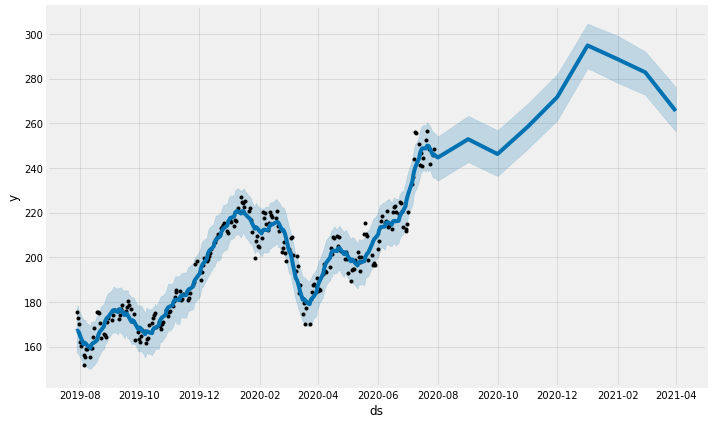

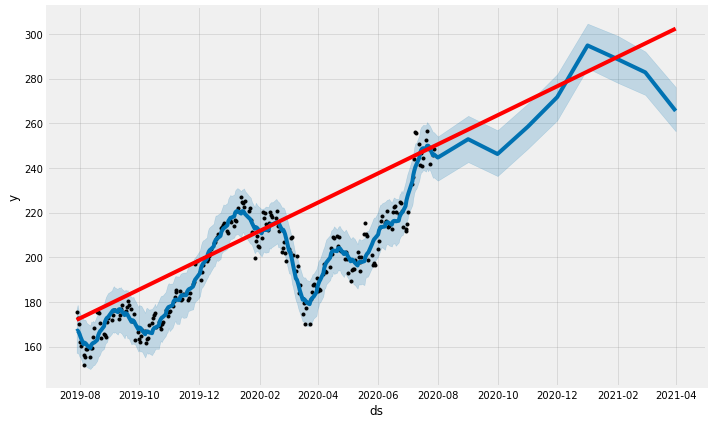

In [8]:
# Look at the model and prediction
my_model.plot(forecast, uncertainty=True)
from fbprophet.plot import add_changepoints_to_plot
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

## Review the components

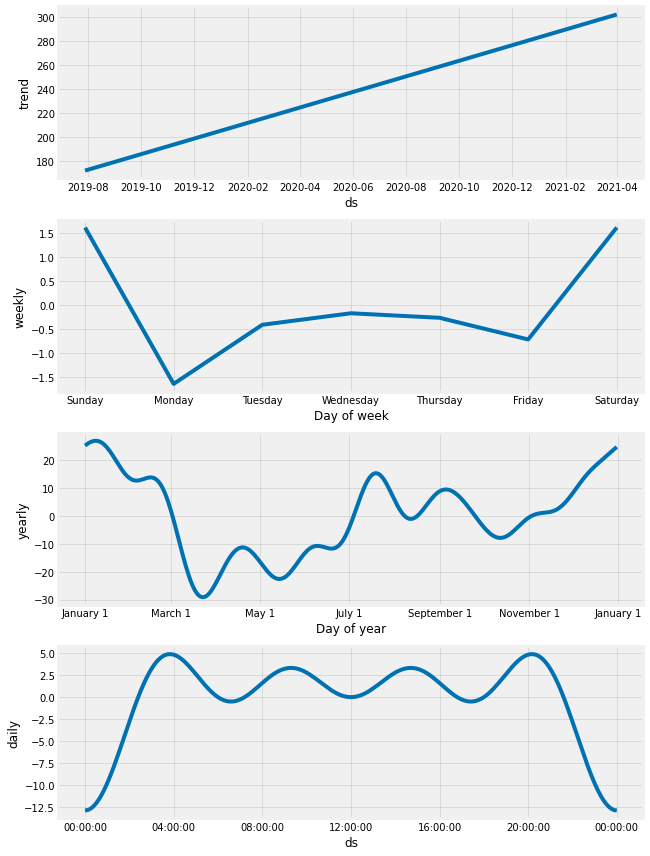

In [9]:
# get components
fig2 = my_model.plot_components(forecast)


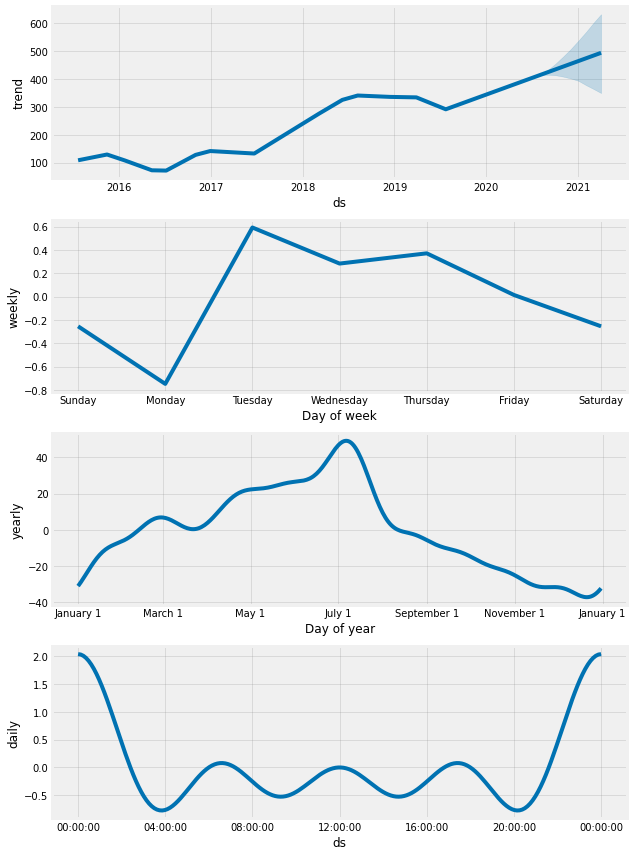

In [ ]:
# get components
fig2 = my_model.plot_components(forecast)


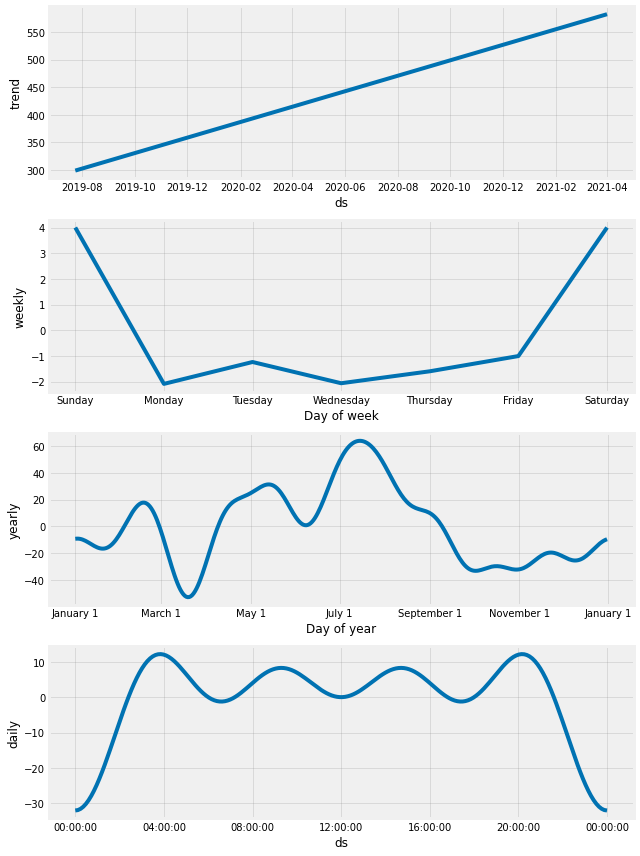

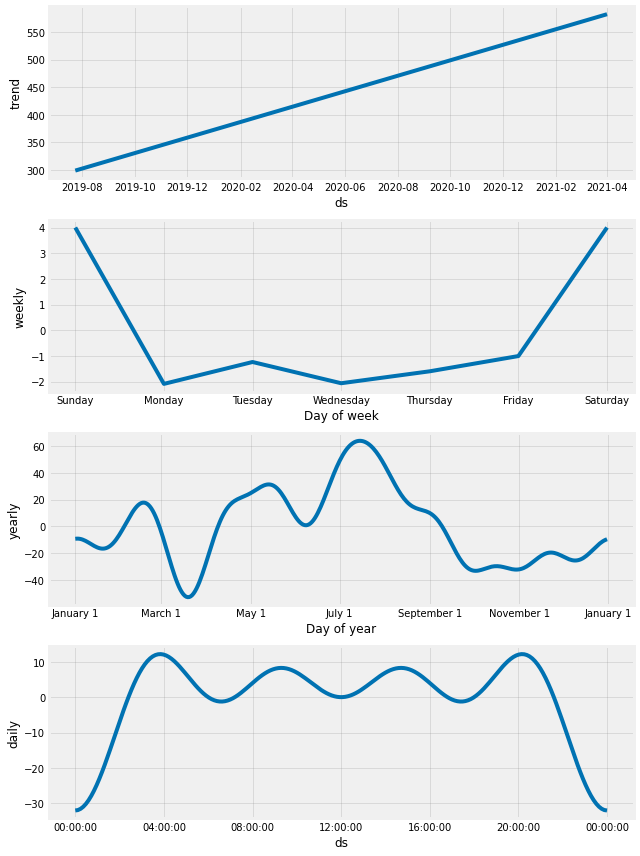

In [ ]:
# get components
fig2 = my_model.plot_components(forecast)
fig2

# Air Traffic stuff for reference


##Get data/ See data from csv file in gdrive

In [ ]:
spent_df = pd.read_csv('CCActivity20182020.csv') #from march 2018-current
orders_df = pd.read_csv('DoorDashHistoryCSV.csv', header=None) #from jun 2018-current, set header to none


FileNotFoundError: ignored

In [ ]:
o_df = pd.DataFrame({'restaurant':orders_df[0].iloc[::3].values,
                     'datebill':orders_df[0].iloc[1::3].values,
                    'items':orders_df[0].iloc[2::3].values})
o_df.head(5)

##Explode Data

In [ ]:
o_df['bill'] = o_df['datebill'].str.extract('(\d\d\.\d\d)', expand=True)
o_df['bill'] = o_df['bill'].astype('float')

o_df['date'] = o_df['datebill'].str.extract('(\w\w\w\s\d*\w\w\s\d*\,\s\d*:\d\d\w\w)', expand=True)
o_df['date'] = pd.to_datetime(o_df['date'])
# o_df['dt'] = o_df['dt'].fillna(0)

o_df['items'] = o_df['items'].str.split(pat=r",\ ", expand=False)
o_df.head(5)

In [ ]:
o_df['hr'] = o_df['date'].dt.hour
o_df['dow'] = o_df['date'].dt.dayofweek
o_df['dow'].unique()

In [ ]:
o_df.dtypes
o_df.bfill(axis='rows') # fill the NaNs


In [ ]:
#  === WHERE DID I ORDER THE MOST (ALTAIR ed) #######################################

bars = alt.Chart(o_df).mark_bar().encode(
    alt.Y('restaurant:N', sort="-x", axis=alt.Axis(title='Restaurants')),
    alt.X('count(restaurant):Q', axis=alt.Axis(title='# of Times Ordered', orient='top')),
    color='year(date)',
    tooltip=('sum(bill)')
)

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='sum(bill):Q'
)

(bars + text).properties(height=900)

In [ ]:
#  === WHERE DID I ORDER THE MOST (ALTAIR ed) #######################################

alt.Chart(o_df).mark_bar().encode(
    alt.Y('restaurant:N', sort="-x", axis=alt.Axis(title='Restaurants')),
    alt.X('count(restaurant):Q', axis=alt.Axis(title='# of Times Ordered', orient='top')),
    color='year(date)',
    tooltip=('sum(bill)')
).interactive() 

In [ ]:

#### ==== behavior per month? #####

alt.Chart(o_df).mark_bar().encode(
    x = alt.X('month(date)',axis=alt.Axis(title='Month (years are collapsed)')),
    y = alt.Y('bill',axis=alt.Axis(title='$$$')),
    shape='year(date):O',
    color='year(date):O',
    tooltip=('restaurant','mean(bill)','date','items')
).transform_bin(
    'binned_count', field='date'
).interactive()


In [ ]:

#### ==== behavior per month? #####

alt.Chart(o_df).mark_bar().encode(
    x = alt.X('month(date)',axis=alt.Axis(title='Month (years are collapsed)')),
    y = alt.Y('count()',axis=alt.Axis(title='# of times ordered')),
    shape='year(date):O',
    color='year(date):O',
    tooltip=('restaurant','count()','date','items')
).transform_bin(
    'binned_count', field='date'
).interactive()

In [ ]:
alt.Chart(o_df).mark_point().encode(
    alt.X('month(date):Q', scale=alt.Scale(zero=False)),
    y='count():N',
    color='year:N',
    facet=alt.Facet('year(date):O', columns=1),
).properties(
    width=300,
    height=100,
)

In [ ]:
# =====WHAT DID I ORDER THE MOST (SNS ed) #######################################
food_items =+ o_df['items']

####################################
# OMG THIS LAMBDA FUNCTION IS BOMB #
####################################
food_list = [item for sublist in food_items for item in sublist]

(unique, counts) = np.unique(food_list, return_counts=True)
frequencies = pd.DataFrame(np.asarray((unique, counts)).T)
f_sorted = frequencies.sort_values(by=[1], ascending=False)

for_bar = f_sorted.head(20)

plt.figure(figsize=(15,5))
barchart = sns.barplot(data=for_bar, 
            x=0, y=1,)
barchart.set_xticklabels(barchart.get_xticklabels(),rotation=45)
barchart.set(xlabel='Food', ylabel='Number of Times ordered', title="Top 20 items ordered in the last 2 years")
plt.show()

## Boring. need to break up words into nouns and preparation

In [ ]:
plt.figure(figsize=(15,5))

base = alt.Chart(o_df).mark_circle(opacity=0.5).transform_fold(
    fold=['0', '1', '2', '3', '4','5','6'],
    as_=['whatever', 'wahtever']
).encode(
    alt.X('month(date):O'),
    alt.Y('mean(bill):Q'),
    alt.Color('dow:N'),
    tooltip=('restaurant','mean(bill)','date','items')

)

base + base.transform_loess('date', 'bill', groupby=['dow']).mark_line(size=4)


In [ ]:
spent_df
spent_df.columns

In [ ]:
### ==== but the 9.99 cost to get free shipping is in the way

line = alt.Chart(spent_df).mark_line(
    color='red',
    size=3
).transform_window(
    rolling_mean='mean(Amount)',
    frame=[-15, 15]
).encode(
    x='Transaction Date:T',
    y='rolling_mean:Q'
)

points = alt.Chart(spent_df).mark_point().encode(
    tooltip=('Amount','Transaction Date','Description'),
    x='Transaction Date:T',
    y=alt.Y('Amount:Q',
            axis=alt.Axis(title='$$$'), scale=alt.Scale(domain=[0,-90]))
    
)

points + line
### ==== get rid of them!

In [ ]:
no_fee_df = spent_df.loc[spent_df['Description']!= "DOORDASH DASHPASS"]
no_fee_df['Amount'] = abs(no_fee_df['Amount'])

line = alt.Chart(no_fee_df).mark_line(
    color='red',
    size=3
).transform_window(
    rolling_mean='mean(Amount)',
    frame=[0, 15]
).encode(
    x='Transaction Date:T',
    y='rolling_mean:Q'
)

points = alt.Chart(no_fee_df).mark_circle().encode(
    tooltip=('Amount','Transaction Date:T','Description'),
    x='Transaction Date:T',
    y=alt.Y('Amount:Q',
            axis=alt.Axis(title='$$$'), 
            scale=alt.Scale(domain=[0,90]))
)

points + line

##Prediction stuff

1. what's the spend like every month?
2. what's the likelihood that i'll order particular restaurant on a particular day?



In [ ]:
# change bill to positive numbers
pdf = no_fee_df[['Transaction Date','Amount']]
pdf['Amount'] = abs(pdf['Amount'])
pdf.set_index('Transaction Date').plot(figsize=(12, 8))
plt.show()

In [ ]:
pdf.rename(columns={'Transaction Date': 'ds', 'Amount': 'y'},inplace=True)
# pdf.reset_index(drop=True, inplace=True)
pdf.head(3)
# pdf.set_index('0', drop=True)

In [ ]:
pdf.rename(columns={'DS': 'ds', 'Amount': 'y'},inplace=True)
pdf

In [ ]:
my_model = Prophet(interval_width=0.95)
my_model.fit(pdf)

In [ ]:
future_dates =  my_model.make_future_dataframe(periods=18, freq='MS')
future_dates.tail()

In [ ]:
forecast =  my_model.predict(future_dates)
forecast.tail()

In [ ]:
my_model.plot(forecast, uncertainty=True)
from fbprophet.plot import add_changepoints_to_plot
fig_air = my_model.plot(forecast)
a = add_changepoints_to_plot(fig_air.gca(), my_model, forecast)

In [ ]:
# get components
fig2 = my_model.plot_components(forecast)


In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig_air = my_model.plot(forecast)
a = add_changepoints_to_plot(fig_air.gca(), my_model, forecast)

In [ ]:
fig2 = my_model.plot_components(forecast)


In [ ]:
holidays.UnitedStates()

In [ ]:
# %pip install holidays
# import holidays

holidays_df = pd.DataFrame(holidays.UnitedStates())

holidays_df


# my_model_holidays =Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, holidays=holidays_df, changepoint_prior_scale=2)
# my_model_holidays.add_country_holidays(country_name='US')

# my_model_holidays.fit(pdf)


*month_bill_data*

```
ds	y
0	2018-06	374.50
1	2018-07	233.20
2	2018-08	435.42
3	2018-09	244.20
4	2018-10	324.88
5	2018-11	448.03
6	2018-12	310.50
7	2019-01	228.98
8	2019-02	267.17
9	2019-03	409.84
10	2019-04	242.48
11	2019-05	322.56
12	2019-06	469.28
13	2019-07	100.12
14	2019-08	293.58
15	2019-09	241.41
16	2019-10	441.61
17	2019-11	232.07
18	2019-12	324.14
19	2020-01	415.68
20	2020-02	499.03
21	2020-03	24.79
22	2020-04	204.97
23	2020-05	307.18
```

